# Using Kaggle API to download datasets

In [1]:
#Ensure you have your token set up with kaggle
#  https://www.kaggle.com/docs/api
!pip install kaggle

In [76]:
#search datasets
# !kaggle datasets list -s 'fraud'

In [77]:
# Ensure you have a .kaggle folder in your directory to authentic kaggle api key.  API key will be in a json file
#/Users/DanielleSpring/.kaggle

#download competition dataset
!kaggle competitions download -c ashrae-energy-prediction


ashrae-energy-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
#Import dependencies for zipfile install
import sys
import os

In [78]:
#unzip downloaded folder...ensure you install pip unzip
if sys.version_info >= (3, 6):
    import zipfile
else:
    import zipfile36 as zipfile 


In [6]:
# importing required modules
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "ashrae-energy-prediction.zip"
  
# opening the zip file in READ mode
with ZipFile('ashrae-energy-prediction.zip', 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall('Data')
    print('Done!')

File Name                                             Modified             Size
building_metadata.csv                          2019-10-10 17:20:04        45527
sample_submission.csv                          2019-10-10 17:20:12    447562511
test.csv                                       2019-10-10 17:20:46   1462461085
train.csv                                      2019-10-10 17:22:42    678616640
weather_test.csv                               2019-10-10 17:23:40     14787908
weather_train.csv                              2019-10-10 17:23:42      7450075
Extracting all the files now...
Done!


# Read in csv datasets

In [7]:
# Import data manipulation dependencies
# *************************************************************************
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
import pprint


# Plots
# *************************************************************************
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')


# Modelling and Forecasting
# ************************************************************************
! pip install lightgbm
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Warnings configuration
# ************************************************************************
import warnings
warnings.filterwarnings('ignore')

In [8]:
#Files to Load 
building_data_to_load = "Data/building_metadata.csv"
test_data_to_load = "Data/test.csv"
train_data_to_load = "Data/train.csv"
weathertest_data_to_load = "Data/weather_test.csv"
weathertrain_data_to_load = "Data/weather_train.csv"


In [79]:
# Create a DataFrame for the building data. 
data_building = pd.read_csv(building_data_to_load)

#display the data table for preview
data_building.head()

# Create building dataframe
building_df=pd.DataFrame(data_building)

In [80]:
# Review datatypes and shape
print(building_df.shape)
building_df.dtypes

(1449, 6)


site_id          int64
building_id      int64
primary_use     object
square_feet      int64
year_built     float64
floor_count    float64
dtype: object

In [81]:
#find null values
for column in building_df.columns:
    print(f"Column {column} has {building_df[column].isnull().sum()}null values")

Column site_id has 0null values
Column building_id has 0null values
Column primary_use has 0null values
Column square_feet has 0null values
Column year_built has 774null values
Column floor_count has 1094null values


In [82]:
building_df['floor_count'].value_counts()

1.0     109
2.0      67
4.0      37
3.0      33
5.0      25
6.0      25
8.0      19
7.0      14
9.0       8
11.0      5
10.0      4
12.0      2
13.0      2
19.0      1
21.0      1
16.0      1
14.0      1
26.0      1
Name: floor_count, dtype: int64

In [13]:
#Show all records with null values for floor count
building_df[building_df['floor_count'].isnull()]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [83]:
#review building type by floor count for nan values
building_df.groupby(building_df['primary_use'])

In [14]:
#Assume all floor counts with NaN to be 1
building_df['floor_count']=building_df['floor_count'].fillna(1)

#Change floor_count column from FLOAT to INTEGER
building_df['floor_count'] = building_df['floor_count'].astype(int)

In [15]:
#Review if any building can have year populated....otherwise update with 9999
# building_df.groupby(['building_id','year_built'])['year_built'].count().sort_values(ascending=False)

#Show all records with null values for year by building_id
building_df[building_df['year_built'].isnull()]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
105,1,105,Education,50623,NaN,5
106,1,106,Education,5374,NaN,4
112,1,112,Education,32206,NaN,6
116,1,116,Education,37265,NaN,5
127,1,127,Lodging/residential,27071,NaN,6
...,...,...,...,...,...,...
1357,15,1357,Office,21618,NaN,1
1370,15,1370,Education,4773,NaN,1
1395,15,1395,Lodging/residential,98624,NaN,1
1421,15,1421,Education,47934,NaN,1


In [16]:
#Assume all year built with NaN to be '9999'
building_df['year_built']=building_df['year_built'].fillna(9999)

#Change floor_count column from FLOAT to INTEGER
building_df['year_built'] = building_df['year_built'].astype(int)

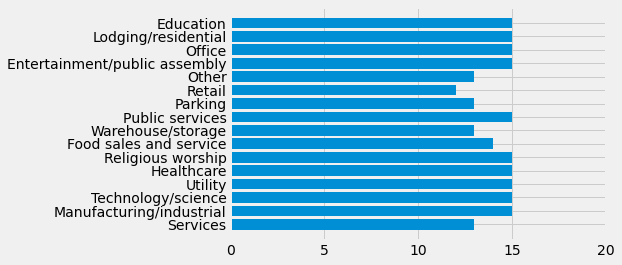

In [17]:
# review building type by site
x_axis =building_df['primary_use']
y_axis = building_df['site_id']

plt.barh(x_axis, y_axis)
plt.xticks(np.arange(0,25,step=5.0))
plt.gca().invert_yaxis()

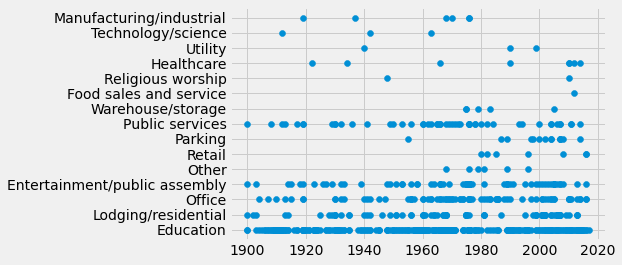

In [84]:
# review building type by site
data=building_df

plt.scatter(building_df['year_built'],building_df['primary_use'])
# plt.xticks(building_df['primary_use'], labels, rotation=90)
plt.show()

In [19]:
# Create a DataFrame for the building data. 
test_df = pd.read_csv(test_data_to_load)

#display the data table for preview
test_df.head()



,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [22]:
test_df['meter'].value_counts()

0    24755760
1     8724960
2     5676480
3     2540400
Name: meter, dtype: int64

In [23]:
# Review datatypes and shape
print(test_df.shape)
test_df.dtypes

(41697600, 4)


row_id          int64
building_id     int64
meter           int64
timestamp      object
dtype: object

In [24]:
# Drop column row_id....not needed
test_df.drop(columns=['row_id'], inplace=True)

#Add column for file type
test_df['file_type']='Meter_test'

#Change timestamp column from object to datetime 2017-01-01 00:00:00....put in hours, min and seconds
test_df['timestamp'] =  pd.to_datetime(test_df['timestamp'], format='%Y-%m-%d %X')

#Add column for year, month, day of the year
test_df['year']= test_df.timestamp.dt.year
test_df['month'] = test_df.timestamp.dt.month
test_df['hour'] = test_df.timestamp.dt.hour
test_df['day_of_week'] = test_df.timestamp.dt.dayofweek
test_df.tail()

,building_id,meter,timestamp,file_type,year,month,hour,day_of_week
41697595,1444,0,2018-05-09 07:00:00,Meter_test,2018,5,7,2
41697596,1445,0,2018-05-09 07:00:00,Meter_test,2018,5,7,2
41697597,1446,0,2018-05-09 07:00:00,Meter_test,2018,5,7,2
41697598,1447,0,2018-05-09 07:00:00,Meter_test,2018,5,7,2
41697599,1448,0,2018-05-09 07:00:00,Meter_test,2018,5,7,2


In [25]:
#find null values
for column in test_df.columns:
    print(f"Column {column} has {test_df[column].isnull().sum()}null values")

Column building_id has 0null values
Column meter has 0null values
Column timestamp has 0null values
Column file_type has 0null values
Column year has 0null values
Column month has 0null values
Column hour has 0null values
Column day_of_week has 0null values


In [26]:
# Create a DataFrame for the building data. 
train_df = pd.read_csv(train_data_to_load)

#display the data table for preview
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [27]:
# Review datatypes and shape
print(train_df.shape)
train_df.dtypes

(20216100, 4)


building_id        int64
meter              int64
timestamp         object
meter_reading    float64
dtype: object

In [28]:
#Add column for file type
train_df['file_type']='Meter_train'

#Change timestamp column from object to datetime 2017-01-01 00:00:00....put in hours, min and seconds
train_df['timestamp'] =  pd.to_datetime(train_df['timestamp'], format='%Y-%m-%d %X')

#Add column for year, month, day of the year
train_df['year']= train_df.timestamp.dt.year
train_df['month'] = train_df.timestamp.dt.month
train_df['hour'] = train_df.timestamp.dt.hour
train_df['day_of_week'] = train_df.timestamp.dt.dayofweek
train_df.tail()

,building_id,meter,timestamp,meter_reading,file_type,year,month,hour,day_of_week
20216095,1444,0,2016-12-31 23:00:00,8.750,Meter_train,2016,12,23,5
20216096,1445,0,2016-12-31 23:00:00,4.825,Meter_train,2016,12,23,5
20216097,1446,0,2016-12-31 23:00:00,0.000,Meter_train,2016,12,23,5
20216098,1447,0,2016-12-31 23:00:00,159.575,Meter_train,2016,12,23,5
20216099,1448,0,2016-12-31 23:00:00,2.850,Meter_train,2016,12,23,5


In [29]:
# Create a DataFrame for the building data. 
weathertest_df = pd.read_csv(weathertest_data_to_load)

#display the data table for preview
weathertest_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [30]:
# Review datatypes and shape
print(weathertest_df.shape)
weathertest_df.dtypes

(277243, 9)


site_id                 int64
timestamp              object
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

In [31]:
#Add column for file type
weathertest_df['file_type']='WeatherMeter_test'

#Change timestamp column from object to datetime 2017-01-01 00:00:00....put in hours, min and seconds
weathertest_df['timestamp'] =  pd.to_datetime(weathertest_df['timestamp'], format='%Y-%m-%d %X')

#Add column for year, month, day of the year
weathertest_df['year']= weathertest_df.timestamp.dt.year
weathertest_df['month'] = weathertest_df.timestamp.dt.month
weathertest_df['hour'] = weathertest_df.timestamp.dt.hour
weathertest_df['day_of_week'] = weathertest_df.timestamp.dt.dayofweek
weathertest_df.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,file_type,year,month,hour,day_of_week
277238,15,2018-12-31 19:00:00,3.3,NaN,1.7,NaN,1018.3,150.0,7.7,WeatherMeter_test,2018,12,19,0
277239,15,2018-12-31 20:00:00,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,WeatherMeter_test,2018,12,20,0
277240,15,2018-12-31 21:00:00,2.8,NaN,1.7,-1.0,1017.2,140.0,6.2,WeatherMeter_test,2018,12,21,0
277241,15,2018-12-31 22:00:00,2.8,NaN,2.2,8.0,1016.1,140.0,5.1,WeatherMeter_test,2018,12,22,0
277242,15,2018-12-31 23:00:00,3.3,NaN,2.2,20.0,1014.7,140.0,5.1,WeatherMeter_test,2018,12,23,0


In [32]:
#find null values
for column in weathertest_df.columns:
    print(f"Column {column} has {weathertest_df[column].isnull().sum()}null values")

Column site_id has 0null values
Column timestamp has 0null values
Column air_temperature has 104null values
Column cloud_coverage has 140448null values
Column dew_temperature has 327null values
Column precip_depth_1_hr has 95588null values
Column sea_level_pressure has 21265null values
Column wind_direction has 12370null values
Column wind_speed has 460null values
Column file_type has 0null values
Column year has 0null values
Column month has 0null values
Column hour has 0null values
Column day_of_week has 0null values


In [33]:
# Create a DataFrame for the building data. 
weathertrain_df = pd.read_csv(weathertrain_data_to_load)

#display the data table for preview
weathertrain_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [34]:
# Review datatypes and shape
print(weathertrain_df.shape)
weathertrain_df.dtypes

(139773, 9)


site_id                 int64
timestamp              object
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

In [35]:
#Add column for file type
weathertrain_df['file_type']='WeatherMeter_train'

#Change timestamp column from object to datetime 2017-01-01 00:00:00....put in hours, min and seconds
weathertrain_df['timestamp'] =  pd.to_datetime(weathertrain_df['timestamp'], format='%Y-%m-%d %X')

#Add column for year, month, day of the year
weathertrain_df['year']= weathertrain_df.timestamp.dt.year
weathertrain_df['month'] = weathertrain_df.timestamp.dt.month
weathertrain_df['hour'] = weathertrain_df.timestamp.dt.hour
weathertrain_df['day_of_week'] = weathertrain_df.timestamp.dt.dayofweek
weathertrain_df.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,file_type,year,month,hour,day_of_week
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7,WeatherMeter_train,2016,12,19,5
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7,WeatherMeter_train,2016,12,20,5
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1,WeatherMeter_train,2016,12,21,5
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6,WeatherMeter_train,2016,12,22,5
139772,15,2016-12-31 23:00:00,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8,WeatherMeter_train,2016,12,23,5


# Merge datafiles for datacleansing

In [37]:
#consolidate meter dataframes
data_meter = pd.concat([train_df,test_df],ignore_index = True, sort = False)


# Create meter dataframe
meter_df=pd.DataFrame(data_meter)

# meter_df.tail()
meter_df.head()

,building_id,meter,timestamp,meter_reading,file_type,year,month,hour,day_of_week
0,0,0,2016-01-01,0.0,Meter_train,2016,1,0,4
1,1,0,2016-01-01,0.0,Meter_train,2016,1,0,4
2,2,0,2016-01-01,0.0,Meter_train,2016,1,0,4
3,3,0,2016-01-01,0.0,Meter_train,2016,1,0,4
4,4,0,2016-01-01,0.0,Meter_train,2016,1,0,4


In [38]:
#consolidate weather dataframes
data_weather = pd.concat([weathertrain_df,weathertest_df],ignore_index = True, sort = False)
data_weather['year_month']=data_weather['timestamp'].dt.to_period('M')

#Create Weather DataFrame
weather_df=pd.DataFrame(data_weather)


In [71]:
weather_df.index.sum(value_counts())

AttributeError: 'Int64Index' object has no attribute 'sum'

In [67]:
# Data preparation
# ==============================================================================
data = weather_df.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('timestamp')
data = data.sort_index()
data.head(2)

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,file_type,year,month,hour,day_of_week,year_month
timestamp,,,,,,,,,,,,,,
2016-01-01,0,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,WeatherMeter_train,2016,1,0,4,2016-01
2016-01-01,2,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6,WeatherMeter_train,2016,1,0,4,2016-01


In [39]:
# Create variables for average, min and max air temperatures
temperature=pd.DataFrame(weather_df[{'site_id', 'year_month','hour','air_temperature'}])
temperature



# temp_avg = temperature.groupby(['site_id','year_month', 'hour']).mean([[air_temperature'])
# temp_avg
# # weather_df=pd.DataFrame(temp_avg)
# weather_df
# temp_max = weather_df.groupby(['site_id','year_month', 'hour']).max([['air_temperature']])
# temp_max
# temp_min = weather_df.groupby(['site_id','year_month', 'hour']).min([['air_temperature']])

# # Create new DataFrame showing average, min, max of temperatures per period/hour and site
# temp_df = pd.DataFrame({
#     "avg_temp" : temp_avg,
#     "max_temp":temp_max,
#     "min_temp" : temp_min})

# temp_df.head()

,air_temperature,site_id,hour,year_month
0,25.0,0,0,2016-01
1,24.4,0,1,2016-01
2,22.8,0,2,2016-01
3,21.1,0,3,2016-01
4,20.0,0,4,2016-01
...,...,...,...,...
417011,3.3,15,19,2018-12
417012,2.8,15,20,2018-12
417013,2.8,15,21,2018-12
417014,2.8,15,22,2018-12


In [63]:
period=weather_df['year_month']
temperature = weather_df['air_temperature']
t_average = temperature.rolling(window=7).mean()

TypeError: float() argument must be a string or a number, not 'Period'

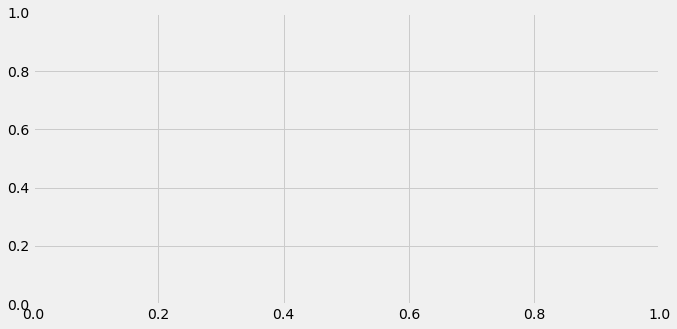

In [65]:
plt.figure(figsize=(10, 5))
# plt.plot(temperature, 'k-', label='Original')
plt.plot(temperature, period, label='Original')
# plt.plot(t_average, 'r-', label='Running average')
plt.plot(t_average, period, label='Running average')
plt.ylabel('Temperature (deg C)')
plt.xlabel('Date')
plt.grid(linestyle=':')
plt.fill_between(t_average.index,0, t_average, color='r', alpha=0.1)
plt.legend(loc='upper left')
plt.show()


# #calculate a moving average
# temp_avg = temp.rolling(window=3).mean()



# # Draw Plot
# def plot_df(weather_df, x, y, title="", xlabel='year_month', ylabel='air_temperature', dpi=100):
#     plt.figure(figsize=(16,5), dpi=dpi)
#     plt.plot(x, y, color='tab:red')
#     plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
#     plt.show()

# plot_df(weather_df, x=weather_df['year_month'].index, y=weather_df['air_temperature'], title='')

# Review  NaN values of weather columns

In [42]:
#sort weather dataframe to ascending by site_id and timestamp
weather_df = weather_df.sort_values(['site_id','timestamp'], ascending=[True,True])


In [43]:
# Fill NAN with last valid value
# weather_df.loc[weather_df['wind_direction']>=1, 'wind_speed']=weather_df['wind_speed'].fillna(method='ffill', inplace=True)
weather_df['wind_speed'].fillna(method='ffill', inplace=True)

#Review NaN value counts
for column in weather_df.columns:
    print(f"Column {column} has {weather_df[column].isnull().sum()}null values")


# # Fill NAN with next valid value
# df[column_name].fillna(method='backfill', inplace=True)


Column site_id has 0null values
Column timestamp has 0null values
Column air_temperature has 159null values
Column cloud_coverage has 209621null values
Column dew_temperature has 440null values
Column precip_depth_1_hr has 145877null values
Column sea_level_pressure has 31883null values
Column wind_direction has 18638null values
Column wind_speed has 0null values
Column file_type has 0null values
Column year has 0null values
Column month has 0null values
Column hour has 0null values
Column day_of_week has 0null values
Column year_month has 0null values


In [44]:
# def fill_nan_with_mean_from_prev_and_next(df):
#         NANrows = pd.isnull(df).any(1).nonzero()[0]
#         null_df = df.isnull()
#         for row in NANrows :
#             for colum in range(0,df.shape[1]):
#                 if(null_df.iloc[row][colum]):
#                     df.iloc[row][colum] = (df.iloc[row-1][colum]+df.iloc[row-1][colum])/2

#         return df

In [45]:
# # Drop First Name rows with missing information
# sunshine_data_df = sunshine_data_df.dropna(how='any')

# Review demand vs Features

In [ ]:
# demand ahead vs temperature

In [ ]:
# demand ahead vs demand now


# should use pyspark?????
# Reading in Datasets into pyspark

In [46]:
# #Using pyspark
# !pip install pyspark

In [47]:
# import os
# # Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# # For example:
# # spark_version = 'spark-3.0.3'
# spark_version = 'spark-3.2.0'
# os.environ['SPARK_VERSION']=spark_version

# # Install Spark and Java
# !apt-get update
# !apt-get install openjdk-11-jdk-headless -qq > /dev/null
# !wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
# !tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
# !pip install -q findspark

# # Set Environment Variables
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# # Start a SparkSession
# import findspark
# findspark.init()


In [48]:
# #download a Postgres driver that will allow Spark to interact with Postgres
# !wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

In [49]:
# #start a Spark session with an additional option that adds the driver to Spark
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("Ashrae_Energy_Predictor").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [50]:
# #  load the dataset and create sprk dataframe
# df=spark.read.csv('../Data/building_metadata.csv',inferSchema=True,header=True)


# # Using limit(), or select() or show() to view the data. I often use limit()
# # Using toPandas() method to return Pyspark DataFrame as Pandas table
# df.limit(3).toPandas()

In [51]:
# Building_df = spark.read.csv('Data/building_metadata.csv', header=True, inferSchema=True)

In [52]:
# Building_df.show(10)